In [1]:
import syft as sy
import copy
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
#Determine if there is a GPU
train_on_gpu = torch.cuda.is_available()
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
PATH_train="./train"
PATH_val="./val"
PATH_test="./test"

In [4]:
TRAIN =Path(PATH_train)
VALID = Path(PATH_val)
TEST=Path(PATH_test)
print(TRAIN)
print(VALID)
print(TEST)

train
val
test


In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# learning rate
LR = 0.001

In [6]:
# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [7]:
# choose the training and test datasets
train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
valid_data = datasets.ImageFolder(VALID,transform=valid_transforms)
test_data = datasets.ImageFolder(TEST, transform=test_transforms)


In [8]:
test_data

Dataset ImageFolder
    Number of datapoints: 1622
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(50, 50), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
print(train_data.class_to_idx)
print(valid_data.class_to_idx)
print(test_data.class_to_idx)

{'sick': 0, 'unsick': 1}
{'sick': 0, 'unsick': 1}
{'sick': 0, 'unsick': 1}


In [10]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)

In [11]:
images,labels=next(iter(train_loader))
images.shape,labels.shape

(torch.Size([32, 3, 50, 50]), torch.Size([32]))

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
classes = ['sick','unsick']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])


def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image

# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

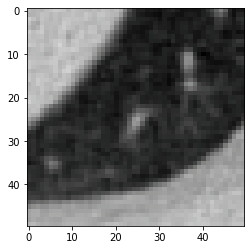

In [13]:
imshow(images[0])

In [14]:
#imshow(images[2])

/home/leo6532/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


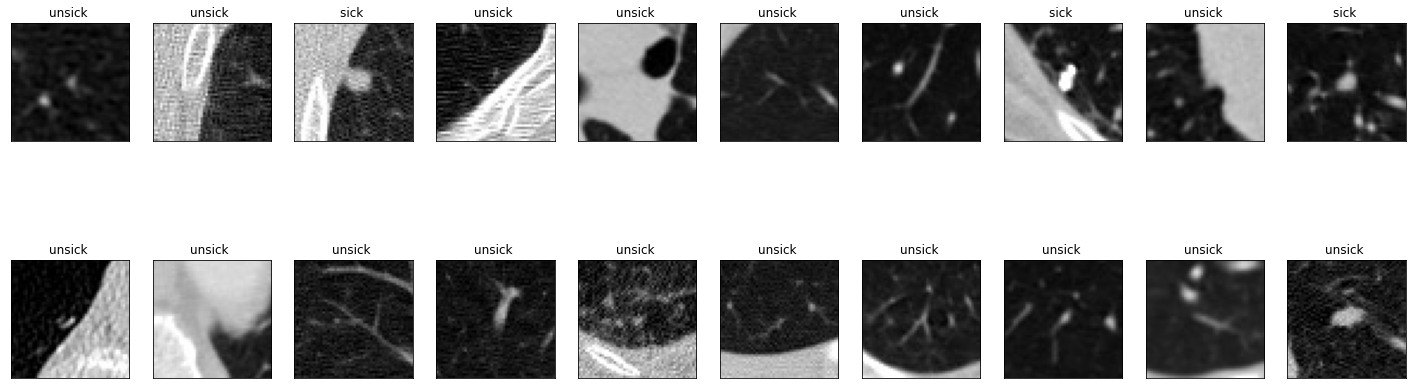

In [15]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
 # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
#display 20 images
for idx in np.arange(20):
     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
     imshow(images[idx])
     ax.set_title("{} ".format( classes[labels[idx]]))

In [16]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0) #output_shape=(16,220,220) 48
        #(224-5+1)/1 #(weigh-kernel+1)/stride 無條件進位
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110) #(220/2) 16 24 24
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0) #output_shape=(32,106,106) 20 20
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=1) #output_shape=(32,53,53) 10 10
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, stride=1, padding=0) #output_shape=(16,51,51) 10 10
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=1) #output_shape=(16,25,25) 5 5
        self.cnn4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1, stride=1, padding=0) #output_shape=(8,23,23) 5 5
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(8,11,11) 8 5 5
        # Fully connected 1 ,#input_shape=(8*12*12)
        self.fc1 = nn.Linear(8 * 11 * 11, 512) 
        #self.relu5 = nn.ReLU() # activation
        self.fc2 = nn.Linear(512, 2) 
        #self.output = nn.Softmax(dim=1)
        
    
    def forward(self, x):
        out = self.cnn1(x) # Convolution 1
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1
        out = self.cnn2(out) # Convolution 2
        out = self.relu2(out) 
        out = self.maxpool2(out) # Max pool 2
        out = self.cnn3(out) # Convolution 3
        out = self.relu3(out)
        out = self.maxpool3(out) # Max pool 3
        out = self.cnn4(out) # Convolution 4
        out = self.relu4(out)
        out = self.maxpool4(out) # Max pool 4
        out = out.view(out.size(0), -1) # last CNN faltten con. Linear NN
        out = self.fc1(out) # Linear function (readout)
        out = self.fc2(out)
        #out = self.output(out)

        return out

In [17]:
model = CNN_Model()
from torchsummary import summary
summary(model.cuda(), (3, 50, 50))
#summary(model, (3, 50, 50),device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
              ReLU-2           [-1, 16, 48, 48]               0
         MaxPool2d-3           [-1, 16, 24, 24]               0
            Conv2d-4           [-1, 32, 22, 22]           4,640
              ReLU-5           [-1, 32, 22, 22]               0
         MaxPool2d-6           [-1, 32, 22, 22]               0
            Conv2d-7           [-1, 16, 22, 22]             528
              ReLU-8           [-1, 16, 22, 22]               0
         MaxPool2d-9           [-1, 16, 22, 22]               0
           Conv2d-10            [-1, 8, 22, 22]             136
             ReLU-11            [-1, 8, 22, 22]               0
        MaxPool2d-12            [-1, 8, 11, 11]               0
           Linear-13                  [-1, 512]         496,128
           Linear-14                   

In [18]:
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

In [19]:
import torch.optim as optim    
optimizer = torch.optim.Adam(model.parameters(), lr=LR) 
criterion = nn.CrossEntropyLoss() 

running epoch: 1



	Training Loss: 0.415362 	Validation Loss: 0.384382
Validation loss decreased (inf --> 0.384382).  Saving model ...
running epoch: 2


/home/leo6532/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN_Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



	Training Loss: 0.351204 	Validation Loss: 0.358448
Validation loss decreased (0.384382 --> 0.358448).  Saving model ...
[0.41536183702663027, 0.35120354935523973]
[0.3843818081050261, 0.35844839494689756]


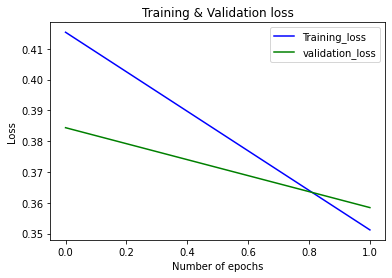

In [20]:
if train_on_gpu:
    model.cuda()
# number of epochs to train the model
n_epochs = 2 #170


valid_loss_min = np.Inf # track change in validation loss

#train_losses,valid_losses=[],[]

train_loss_i = [] 
valid_loss_i = []
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        with torch.no_grad():
            output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    #train_losses.append(train_loss/len(train_loader.dataset))
    #valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        train_loss, valid_loss))
    
    #作圖接收矩陣
    train_loss_i.append(train_loss)
    valid_loss_i.append(valid_loss)

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_CNN.pth')
        torch.save(model, "o_model.pth")
        valid_loss_min = valid_loss
#作圖區
print(train_loss_i) 
print(valid_loss_i)

plt.plot(range(n_epochs), train_loss_i,'b-', label='Training_loss')
plt.plot(range(n_epochs), valid_loss_i,'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
target

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')

#TEST MODEL

In [22]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [23]:
use_cuda = torch.cuda.is_available()
model.cuda()
test(test_loader, model, criterion, use_cuda)

Test Loss: 0.330786
Test Accuracy: 84% (1373/1622)


In [24]:
model_1 = torch.load('model_CNN.pth')

In [25]:
model_1

OrderedDict([('cnn1.weight',
              tensor([[[[ 7.8462e-02,  1.7721e-02,  1.2566e-01],
                        [ 9.9183e-02, -1.1433e-01, -8.6880e-02],
                        [-6.0243e-02,  9.2623e-02,  1.0050e-03]],
              
                       [[ 1.3084e-01, -1.2047e-01,  3.4673e-02],
                        [ 1.3258e-03, -2.4090e-02,  1.7466e-01],
                        [ 8.9963e-02,  1.0861e-01, -6.1762e-02]],
              
                       [[-7.3555e-02, -1.3800e-01,  8.3165e-02],
                        [-3.6034e-02, -1.7168e-01, -5.4591e-02],
                        [-1.7466e-01,  8.8419e-02,  5.0878e-02]]],
              
              
                      [[[-7.4155e-02, -1.0666e-01, -8.5641e-02],
                        [ 4.4024e-02,  1.5256e-01, -2.0718e-01],
                        [-4.5603e-02,  1.7051e-01, -1.0462e-01]],
              
                       [[ 2.7502e-02,  9.4086e-02,  5.3428e-02],
                        [ 2.3486e-02, -1.0808e

# 虛擬環境執行 model

In [26]:
hook = sy.TorchHook(torch)
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
secure_worker = sy.VirtualWorker(hook, id="secure_worker")
compute_nodes = [bob, alice]


In [27]:
bobs_data = data.cuda()
bobs_target = target.cuda()

alices_data = data.cuda()
alices_target = target.cuda()

In [83]:
bobs_model = model.copy().send(bob)
alices_model = model

In [29]:
bobs_opt = optim.SGD(params=bobs_model.parameters(),lr=0.1)   
alices_opt = optim.SGD(params=alices_model.parameters(),lr=0.1) 
#optimizer = torch.optim.Adam(model.parameters(), lr=LR) 
#criterion = nn.CrossEntropyLoss() 

# Training Nodes model

In [30]:
for i in range(10):

    # Train Bob's Model
    
    bobs_opt.zero_grad()
    bobs_pred = bobs_model(bobs_data)
    bobs_loss = criterion(bobs_pred,bobs_target)
    bobs_loss.backward()

    bobs_opt.step()
    bobs_loss += loss.item()*data.size(0)
    #bobs_loss = bobs_loss.get().data

    # Train Alice's Model
    alices_opt.zero_grad()
    alices_pred = alices_model(alices_data)
    alices_loss = criterion(alices_pred,alices_target)
    alices_loss.backward()

    alices_opt.step()
    alices_loss += loss.item()*data.size(0)
    #alices_loss = alices_loss.get().data
    
    print("Bob:" + str(bobs_loss) + " Alice:" + str(alices_loss))

    

Bob:tensor(7.7494, device='cuda:0', grad_fn=<AddBackward0>) Alice:tensor(7.7132, device='cuda:0', grad_fn=<AddBackward0>)
Bob:tensor(7.6676, device='cuda:0', grad_fn=<AddBackward0>) Alice:tensor(7.7723, device='cuda:0', grad_fn=<AddBackward0>)
Bob:tensor(8.3612, device='cuda:0', grad_fn=<AddBackward0>) Alice:tensor(7.8362, device='cuda:0', grad_fn=<AddBackward0>)
Bob:tensor(7.8214, device='cuda:0', grad_fn=<AddBackward0>) Alice:tensor(7.8132, device='cuda:0', grad_fn=<AddBackward0>)
Bob:tensor(7.8046, device='cuda:0', grad_fn=<AddBackward0>) Alice:tensor(7.7875, device='cuda:0', grad_fn=<AddBackward0>)
Bob:tensor(7.7658, device='cuda:0', grad_fn=<AddBackward0>) Alice:tensor(7.7329, device='cuda:0', grad_fn=<AddBackward0>)
Bob:tensor(7.6626, device='cuda:0', grad_fn=<AddBackward0>) Alice:tensor(7.6195, device='cuda:0', grad_fn=<AddBackward0>)
Bob:tensor(7.5991, device='cuda:0', grad_fn=<AddBackward0>) Alice:tensor(7.6406, device='cuda:0', grad_fn=<AddBackward0>)
Bob:tensor(8.0460, devic

# Model's  weight Calculation

In [104]:
weight = []
params=bobs_model.state_dict() 
for k,v in params.items():
    print(k)
    
    
print((params['cnn1.weight']*5).get())
print(model.state_dict())


cnn1.weight
cnn1.bias
cnn2.weight
cnn2.bias
cnn3.weight
cnn3.bias
cnn4.weight
cnn4.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
tensor([[[[ 4.1362e-01,  1.0776e-01,  6.4416e-01],
          [ 5.1558e-01, -5.5281e-01, -4.1876e-01],
          [-2.8718e-01,  4.7890e-01,  1.4969e-02]],

         [[ 6.7656e-01, -5.8221e-01,  1.9014e-01],
          [ 2.7288e-02, -1.0065e-01,  8.8984e-01],
          [ 4.6472e-01,  5.5974e-01, -2.9809e-01]],

         [[-3.4457e-01, -6.6902e-01,  4.3348e-01],
          [-1.5865e-01, -8.3773e-01, -2.5552e-01],
          [-8.5752e-01,  4.5967e-01,  2.6602e-01]]],


        [[[-3.7949e-01, -5.5288e-01, -4.2820e-01],
          [ 2.0875e-01,  7.5964e-01, -1.0183e+00],
          [-2.2727e-01,  8.6528e-01, -4.9288e-01]],

         [[ 1.2480e-01,  4.4664e-01,  2.6335e-01],
          [ 1.0201e-01, -5.4741e-01, -1.0063e+00],
          [-6.6832e-01,  1.6010e-01,  4.0936e-01]],

         [[ 6.5557e-01, -9.4873e-01, -1.0176e+00],
          [ 3.6120e-01,  8.0125e-01,  5.6362

In [82]:
print(model.state_dict())

OrderedDict([('cnn1.weight', tensor([[[[ 8.2724e-02,  2.1551e-02,  1.2883e-01],
          [ 1.0312e-01, -1.1056e-01, -8.3752e-02],
          [-5.7436e-02,  9.5780e-02,  2.9937e-03]],

         [[ 1.3531e-01, -1.1644e-01,  3.8029e-02],
          [ 5.4575e-03, -2.0130e-02,  1.7797e-01],
          [ 9.2944e-02,  1.1195e-01, -5.9617e-02]],

         [[-6.8915e-02, -1.3380e-01,  8.6696e-02],
          [-3.1729e-02, -1.6755e-01, -5.1105e-02],
          [-1.7150e-01,  9.1935e-02,  5.3204e-02]]],


        [[[-7.5898e-02, -1.1058e-01, -8.5640e-02],
          [ 4.1750e-02,  1.5193e-01, -2.0366e-01],
          [-4.5455e-02,  1.7306e-01, -9.8577e-02]],

         [[ 2.4961e-02,  8.9328e-02,  5.2669e-02],
          [ 2.0402e-02, -1.0948e-01, -2.0126e-01],
          [-1.3366e-01,  3.2020e-02,  8.1872e-02]],

         [[ 1.3111e-01, -1.8975e-01, -2.0352e-01],
          [ 7.2239e-02,  1.6025e-01,  1.1272e-02],
          [ 2.0428e-02,  1.3659e-01, -1.2073e-01]]],


        [[[-3.7078e-02, -4.0148e-03, 

# Print model's all weight

In [79]:
for name, para in bobs_model.named_parameters():
    print('{}: {}'.format(name, para.shape))
    #print(para.shape)
for name, para in alices_model.named_parameters():
    print('{}: {}'.format(name, para.shape))
    #print(para.shape)    


cnn1.weight: torch.Size([16, 3, 3, 3])
cnn1.bias: torch.Size([16])
cnn2.weight: torch.Size([32, 16, 3, 3])
cnn2.bias: torch.Size([32])
cnn3.weight: torch.Size([16, 32, 1, 1])
cnn3.bias: torch.Size([16])
cnn4.weight: torch.Size([8, 16, 1, 1])
cnn4.bias: torch.Size([8])
fc1.weight: torch.Size([512, 968])
fc1.bias: torch.Size([512])
fc2.weight: torch.Size([2, 512])
fc2.bias: torch.Size([2])
cnn1.weight: torch.Size([16, 3, 3, 3])
cnn1.bias: torch.Size([16])
cnn2.weight: torch.Size([32, 16, 3, 3])
cnn2.bias: torch.Size([32])
cnn3.weight: torch.Size([16, 32, 1, 1])
cnn3.bias: torch.Size([16])
cnn4.weight: torch.Size([8, 16, 1, 1])
cnn4.bias: torch.Size([8])
fc1.weight: torch.Size([512, 968])
fc1.bias: torch.Size([512])
fc2.weight: torch.Size([2, 512])
fc2.bias: torch.Size([2])


In [47]:
import torch
from torchvision import models

m = models.resnet18()
print(m)
print('-'*60)
for l in list(m.named_parameters()):
    print(l[0], ':', l[1].detach().numpy().shape)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  